# The Stock Price Relationship between Apple Inc. and Foxconn

主要是預測鴻海的收盤價的漲跌，輸入的資料沒限定，可以是之前的蘋果公司和鴻海股票的任何資訊(如開盤價,收盤價,成交量...)

## Data Preprocessing
- Load the Apple and Foxconn stock dataset.
- Preprocess the `Date` and `Volume` column.
    - Format `Date` to datetime
    - Adjust `Volume` of Apple and Foxconn to same units
- Remove the outlier in foxconn dataset.
- Align the datetime, and combine above two input source into one dataset.

### Apple Stock

In [21]:
import pandas as pd
import numpy as np

colnames = ['Date', 'Open_A', 'High_A', 'Low_A', 'Close_A', 'Volume_A']

apple = pd.read_csv('apple.csv', encoding = 'utf-8', parse_dates=True)
apple.columns = colnames
apple['Date'] = pd.to_datetime(apple['Date'], format = '%Y/%m/%d')

In [22]:
import re

volume_list = []

# Convert million and million to actual number 
pattern = re.compile(".*[B]")
for i in apple['Volume_A'].values:
    if pattern.match(i):
        i = i.replace(r'.', '').replace(r'B', '00000000')
        volume_list.append(i)
    else:
        i = i.replace(r'.', '').replace(r'M', '000000')
        volume_list.append(i)

apple['Volume_A'] = volume_list

print("Apple Stock : ", apple.shape)
apple.head()

Apple Stock :  (6926, 6)


,Date,Open_A,High_A,Low_A,Close_A,Volume_A
0,1990-01-02,1.3304,1.3393,1.2500,1.3304,4580000000
1,1990-01-03,1.3393,1.3571,1.3393,1.3393,5200000000
2,1990-01-04,1.3437,1.3839,1.3304,1.3437,5538000000
3,1990-01-05,1.3482,1.3661,1.3214,1.3482,3083000000
4,1990-01-08,1.3571,1.3571,1.3214,1.3571,2539000000


### Foxconn Stock

In [23]:
colnames = ['Date', 'Open_F', 'High_F', 'Low_F', 'Close_F', 'Volume_F']

foxconn = pd.read_csv('foxconn.csv', encoding = 'utf-8', parse_dates=True)
foxconn.columns = colnames
foxconn['Date'] = pd.to_datetime(foxconn['Date'], format = '%Y/%m/%d')

# Drop out the first 10 row, because the volume seems weird
foxconn = foxconn.drop(foxconn.index[0:10])
print("Foxconn Stock : ", foxconn.shape)
foxconn.head()

Foxconn Stock :  (6751, 6)


,Date,Open_F,High_F,Low_F,Close_F,Volume_F
10,1991-06-29,85.5,85.5,85.5,85.5,2221
11,1991-07-02,89.0,89.0,82.5,82.5,2670
12,1991-07-03,82.0,82.5,80.0,82.0,1298
13,1991-07-04,80.5,87.5,80.5,87.5,1880
14,1991-07-05,88.0,89.0,85.0,88.0,2475


### Combine Dataset
- Taiwan stock market is influenced by the last day of US stock market
- In order to combine two different stock data, needs to minus US stock datetime by one day.
- Last, only left 4993 valid row data after data preprocessing stage.

In [24]:
from datetime import datetime, timedelta

# Minus Apple stock datetime one day
apple['Date'] = apple['Date'] - timedelta(days=1)
 
# Choose the same period with foxconn
start_date = foxconn.iloc[0, 0]
end_date = foxconn.iloc[-1, 0]

mask = (apple['Date'] >= start_date) & (apple['Date'] <= end_date)
apple = apple.loc[mask]

stock = pd.merge(apple, foxconn, on = 'Date', how = 'inner', indicator = True)
print("Stock size after merge : ", stock.shape)
stock.head()

Stock size after merge :  (4993, 12)


,Date,Open_A,High_A,Low_A,Close_A,Volume_A,Open_F,High_F,Low_F,Close_F,Volume_F,_merge
0,1991-07-02,1.5402,1.5536,1.4911,1.5402,7619000000,89.0,89.0,82.5,82.5,2670,both
1,1991-07-04,1.6295,1.6429,1.5268,1.6295,8289000000,80.5,87.5,80.5,87.5,1880,both
2,1991-07-08,1.6741,1.7232,1.6607,1.6741,5661000000,83.0,86.0,82.0,82.0,1018,both
3,1991-07-09,1.6875,1.7232,1.6696,1.6875,3914000000,83.0,83.5,80.5,82.0,675,both
4,1991-07-10,1.6696,1.6875,1.6429,1.6696,3648000000,83.5,84.0,82.0,84.0,690,both


In [28]:
stock_final = stock.iloc[:, np.r_[1:5, 9]]
stock_final.head()

,Open_A,High_A,Low_A,Close_A,Close_F
0,1.5402,1.5536,1.4911,1.5402,82.5
1,1.6295,1.6429,1.5268,1.6295,87.5
2,1.6741,1.7232,1.6607,1.6741,82.0
3,1.6875,1.7232,1.6696,1.6875,82.0
4,1.6696,1.6875,1.6429,1.6696,84.0


## Split the Training and Test dataset

### * Appedix : Mismatch Date Observation

In [8]:
%matplotlib inline
import seaborn as sns

total = pd.merge(apple, foxconn, on = 'Date', how = 'outer', indicator = True)
total['_merge'].value_counts()

both          4993
right_only    1758
left_only     1555
Name: _merge, dtype: int64

/Users/kennyhsieh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


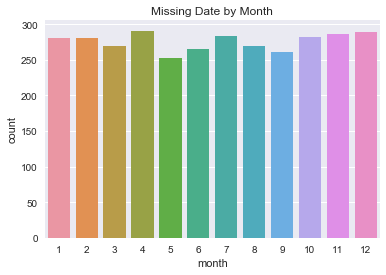

In [9]:
diff_time = total.query('_merge != "both"')
diff_time['month'] = diff_time.loc[:, 'Date'].dt.month

sns.set(style="darkgrid")
ax = sns.countplot(x="month", data=diff_time).set_title('Missing Date by Month')